# Algoritmo de red convolucional para la clasificación detección temprana de supernovas

In [79]:
import numpy as np
import pickle as pkl
import os
import sys
import time
import torch
from torch import nn
import torchvision
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.metrics import classification_report

## Red convolucional

### Se abre la data pre-procesada

In [80]:
# Función para cargar el contenido del archivo .pkl
def load_pickle_data(filename):
    with open(filename, 'rb') as f:
        data = pkl.load(f)
    return data

# Cargar el archivo
filename = 'processed_data.pkl' 
data_procesada = load_pickle_data(filename)

# Visualizar el contenido
print('keys de pkl', data_procesada.keys())
print('keys de Test',data_procesada['Validation'].keys())
data_procesada['Validation']['labels']

keys de pkl dict_keys(['Train', 'Validation', 'Test'])
keys de Test dict_keys(['images', 'labels', 'features'])


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,

In [81]:
def preparar_imagenes_para_modelo(data_dict, key_principal='Train', key_imagenes='images'):
    # Extraer imágenes del diccionario
    imagenes = data_dict[key_principal][key_imagenes]
    
    # Cambiar el orden de las dimensiones a [canales, altura, ancho]
    imagenes = np.transpose(imagenes, (0, 3, 1, 2))
    
    # Convertir a tensor de PyTorch
    imagenes_tensor = torch.tensor(imagenes, dtype=torch.float32)

    
    return imagenes_tensor

# Preparar las imágenes para el modelo
Train = preparar_imagenes_para_modelo(data_procesada)
Val = preparar_imagenes_para_modelo(data_procesada, key_principal='Validation')
Test = preparar_imagenes_para_modelo(data_procesada, key_principal='Test')

print('tipo de dato de Train:', Train.type)
print('forma de Train:', Train.shape)
print('forma de Validation:', Val.shape)
print('forma de Test:', Test.shape)



tipo de dato de Train: <built-in method type of Tensor object at 0x0000011EAA86B510>
forma de Train: torch.Size([72710, 3, 21, 21])
forma de Validation: torch.Size([500, 3, 21, 21])
forma de Test: torch.Size([500, 3, 21, 21])


In [82]:
def extraer_etiquetas(data_dict, key_principal='Train', key_etiquetas='labels'):
    # Extraer etiquetas del diccionario
    etiquetas = data_dict[key_principal][key_etiquetas]
    # Convertir a tensor de PyTorch
    etiquetas_tensor = torch.tensor(etiquetas, dtype=torch.long)  # Usamos dtype long porque son índices de clase
    return etiquetas_tensor


### Extracción de metadata:

In [83]:
def extraer_metadata(data_dict, key_principal='Train', key_metadata='features'):
    # Extraer características de metadatos del diccionario
    metadata = data_dict[key_principal][key_metadata]
    
    # Convertir explícitamente a float32
    metadata = metadata.astype(np.float32)
    
    # Convertir a tensor de PyTorch
    metadata_tensor = torch.tensor(metadata, dtype=torch.float32)
    
    return metadata_tensor


# Extraer características de metadatos para los conjuntos de datos
metadata_train = extraer_metadata(data_procesada)
metadata_val = extraer_metadata(data_procesada, key_principal='Validation')
metadata_test = extraer_metadata(data_procesada, key_principal='Test')

print('forma de metadata_train:', metadata_train.shape)
print('forma de metadata_val:', metadata_val.shape)
print('forma de metadata_test:', metadata_test.shape)

metadata_val[0]


forma de metadata_train: torch.Size([72710, 26])
forma de metadata_val: torch.Size([500, 26])
forma de metadata_test: torch.Size([500, 26])


tensor([ 0.7788, -0.6295,  0.0887,  0.4651,  1.1523,  0.0935,  2.1225, -0.8817,
         1.1350,  1.1945,  0.2198,  0.3951,  1.1309,  0.9652, -0.6643, -0.0798,
        -2.0312, -0.2051, -0.1635,  0.5879,  0.2048,  1.6357, -0.8917, -0.1424,
        -0.2300, -0.1352])

## Modelo convolucional, incorporando invariancia rotacional

In [84]:
class CNNModel(nn.Module):
    def __init__(self, dropout_p, num_classes=5):
        super().__init__()
        # Zero padding para evitar perder datos de las imágenes después de las convoluciones
        self.padding = nn.ZeroPad2d(3)

        # Bloques de convolución
        self.conv_blocks = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # MLP
        self.mlp = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2304, 64),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def rotate_input(self, x):
        # Rotaciones para la invariancia 
        x_90 = torch.rot90(x, 1, [2, 3])
        x_180 = torch.rot90(x, 2, [2, 3])
        x_270 = torch.rot90(x, 3, [2, 3])
        return torch.cat([x, x_90, x_180, x_270], dim=0)

    def cyclic_pooling(self, x):
        B = x.size(0) // 4
        return (x[:B] + x[B:2*B] + x[2*B:3*B] + x[3*B:]) / 4.0

    def forward(self, x):
        # Zero padding
        x = self.padding(x)
        
        # Rotación de la entrada
        x_rotated = self.rotate_input(x)
        
        # Pasar por bloques convolucionales
        x_rotated = self.conv_blocks(x_rotated)
        
        # Pooling Cíclico
        x_pooled = self.cyclic_pooling(x_rotated)
        
        # Pasar por MLP
        out = self.mlp(x_pooled)
        
        return out


## Función de entrenamiento y visualización

In [85]:
def show_curves(curves):
    fig, ax = plt.subplots(1, 2, figsize=(13, 5))
    fig.set_facecolor('white')

    epochs = np.arange(len(curves["val_loss"])) + 1

    ax[0].plot(epochs, curves['val_loss'], label='validation')
    ax[0].plot(epochs, curves['train_loss'], label='training')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Loss evolution during training')
    ax[0].legend()

    ax[1].plot(epochs, curves['val_acc'], label='validation')
    ax[1].plot(epochs, curves['train_acc'], label='training')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Accuracy evolution during training')
    ax[1].legend()

    plt.show()

In [86]:
def train_step(x_batch, y_batch, model, optimizer, criterion, use_gpu):
    # Predicción
    y_predicted = model(x_batch)

    # Cálculo de loss
    loss = criterion(y_predicted, y_batch)

    # Actualización de parámetros
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return y_predicted, loss


def evaluate(val_loader, model, criterion, use_gpu):
    cumulative_loss = 0
    cumulative_predictions = 0
    data_count = 0

    for x_val, y_val in val_loader:
        if use_gpu:
            x_val = x_val.cuda()
            y_val = y_val.cuda()

        y_predicted = model(x_val)
        
        loss = criterion(y_predicted, y_val)

        class_prediction = torch.argmax(y_predicted, axis=1).long()

        cumulative_predictions += (y_val == class_prediction).sum().item()
        cumulative_loss += loss.item()
        data_count += y_val.shape[0]

    val_acc = cumulative_predictions / data_count
    val_loss = cumulative_loss / len(val_loader)

    return val_acc, val_loss



def train_model(
    model,
    train_data_images,
    train_data_labels,
    val_data_images,
    val_data_labels,
    epochs,
    criterion,
    batch_size,
    lr,
    use_gpu,
    patience=5
):

    if use_gpu:
        model.cuda()

    # Definición de dataloader
    train_dataset = torch.utils.data.TensorDataset(train_data_images, train_data_labels)
    val_dataset = torch.utils.data.TensorDataset(val_data_images, val_data_labels)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=use_gpu)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_data_images), shuffle=False, pin_memory=use_gpu)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    curves = {
        "train_acc": [],
        "val_acc": [],
        "train_loss": [],
        "val_loss": [],
    }

    t0 = time.perf_counter()
    best_val_loss = float('inf')
    epochs_without_improvement = 0

    for epoch in range(epochs):
        print(f"\rEpoch {epoch + 1}/{epochs}")
        cumulative_train_loss = 0
        cumulative_train_corrects = 0
        train_loss_count = 0
        train_acc_count = 0

        # Entrenamiento del modelo
        model.train()

        for i, data in enumerate(train_loader):
            (x_batch, y_batch) = data  
            if use_gpu:
                x_batch = x_batch.cuda()
                y_batch = y_batch.cuda()

            y_predicted, loss = train_step(x_batch, y_batch, model, optimizer, criterion, use_gpu)

            cumulative_train_loss += loss.item()
            train_loss_count += 1
            train_acc_count += y_batch.shape[0]

            # Calculamos número de aciertos
            class_prediction = torch.argmax(y_predicted, axis=1).long()
            cumulative_train_corrects += (y_batch == class_prediction).sum().item()

            # if (i + 1) % 117 == 0:
            #     print(f"Iteration {i + 1} - Batch {i + 1}/{len(train_loader)} - Train loss: {cumulative_train_loss / train_loss_count}, Train acc: {cumulative_train_corrects / train_acc_count}")

        model.eval()
        with torch.no_grad():
            val_acc, val_loss = evaluate(val_loader, model, criterion, use_gpu)

        print(f"Val loss: {val_loss}, Val acc: {val_acc}")

        train_loss = cumulative_train_loss / train_loss_count
        train_acc = cumulative_train_corrects / train_acc_count

        curves["train_acc"].append(train_acc)
        curves["val_acc"].append(val_acc)
        curves["train_loss"].append(train_loss)
        curves["val_loss"].append(val_loss)

        # Lógica de early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement == patience:
            print(f"Early stopping at epoch {epoch + 1} due to no improvement after {patience} epochs.")
            break

    print(f"Tiempo total de entrenamiento: {time.perf_counter() - t0:.4f} [s]")
    model.cpu()

    return curves


### Búsqueda de hiperparámetros con funciones de sklearn

In [87]:
# Dividir las imágenes y metadatos en conjuntos de entrenamiento y validación
Train_images = preparar_imagenes_para_modelo(data_procesada)
Val_images = preparar_imagenes_para_modelo(data_procesada, key_principal='Validation')
Train_labels = extraer_etiquetas(data_procesada)
Val_labels = extraer_etiquetas(data_procesada, key_principal='Validation')


In [88]:
# # Wrapper del modelo para Scikit-learn
# class TorchModelWrapper(object):
#     def __init__(self, dropout_p=0.5, batch_size=64, lr=0.001, epochs=30, use_gpu=True):
#         self.dropout_p = dropout_p
#         self.batch_size = batch_size
#         self.lr = lr
#         self.epochs = epochs
#         self.use_gpu = use_gpu
#         self._model = None

#     def get_params(self, deep=True):
#         return {
#             "dropout_p": self.dropout_p,
#             "batch_size": self.batch_size,
#             "lr": self.lr,
#             "epochs": self.epochs,
#             "use_gpu": self.use_gpu
#         }

#     def set_params(self, **parameters):
#         for parameter, value in parameters.items():
#             setattr(self, parameter, value)
#         return self
#     def fit(self, X, y):
#         model = CNNModel(dropout_p=self.dropout_p)
#         criterion = nn.CrossEntropyLoss()
        
#         self._model = train_model(model, X, y, Val_images, Val_labels, self.epochs, criterion, self.batch_size, self.lr, self.use_gpu)

#     def predict(self, X):
#         dataset = torch.utils.data.TensorDataset(X)
#         data_loader = torch.utils.data.DataLoader(dataset, batch_size=len(X), shuffle=False)
        
#         self._model.eval()
#         with torch.no_grad():
#             for inputs in data_loader:
#                 if self.use_gpu:
#                     inputs = inputs.cuda()
#                 outputs = self._model(inputs)
#                 _, preds = torch.max(outputs, 1)
#         return preds.cpu().numpy()

#     def score(self, X, y):
#         y_pred = self.predict(X)
#         return accuracy_score(y, y_pred)


# # Parámetros a considerar en la búsqueda
# param_dist = {
#     'dropout_p': [0.5, 0.6, 0.8],
#     'batch_size': [16, 32, 62],
#     'lr': [5e-3, 1e-3, 5e-4, 1e-4, 5e-5],
#     'epochs': [10, 20, 30, 40, 50]
# }

# # Crear el modelo de búsqueda aleatoria
# random_search = RandomizedSearchCV(
#     estimator=TorchModelWrapper(),
#     param_distributions=param_dist,
#     n_iter=10,
#     scoring=make_scorer(accuracy_score),
#     verbose=1,
#     cv=3,
#     n_jobs=1
# )

# # Lanzar la búsqueda
# random_search.fit(Train_images, Train_labels)

# # Mostrar los mejores parámetros encontrados
# print("Mejores parámetros encontrados: ", random_search.best_params_)

#### Mejores parámetros encontrados:  {'lr': 5e-05, 'epochs': 50, 'dropout_p': 0.6, 'batch_size': 16}

## Instanciamos el modelo

### Primera combinación de hiperparámetros

Epoch 1/50
Val loss: 0.856783390045166, Val acc: 0.63
Epoch 2/50
Val loss: 0.7765533924102783, Val acc: 0.708
Epoch 3/50
Val loss: 0.7049595713615417, Val acc: 0.72
Epoch 4/50
Val loss: 0.6485992074012756, Val acc: 0.744
Epoch 5/50
Val loss: 0.6158767342567444, Val acc: 0.758
Epoch 6/50
Val loss: 0.5890151262283325, Val acc: 0.77
Epoch 7/50
Val loss: 0.5467100739479065, Val acc: 0.8
Epoch 8/50
Val loss: 0.5166137218475342, Val acc: 0.798
Epoch 9/50
Val loss: 0.529746413230896, Val acc: 0.798
Epoch 10/50
Val loss: 0.5077081918716431, Val acc: 0.822
Epoch 11/50
Val loss: 0.4866856336593628, Val acc: 0.818
Epoch 12/50
Val loss: 0.49538594484329224, Val acc: 0.826
Epoch 13/50
Val loss: 0.48866650462150574, Val acc: 0.838
Epoch 14/50
Val loss: 0.4958358705043793, Val acc: 0.828
Epoch 15/50
Val loss: 0.47403213381767273, Val acc: 0.83
Epoch 16/50
Val loss: 0.49187102913856506, Val acc: 0.83
Epoch 17/50
Val loss: 0.48912495374679565, Val acc: 0.83
Epoch 18/50
Val loss: 0.5161759257316589, Val

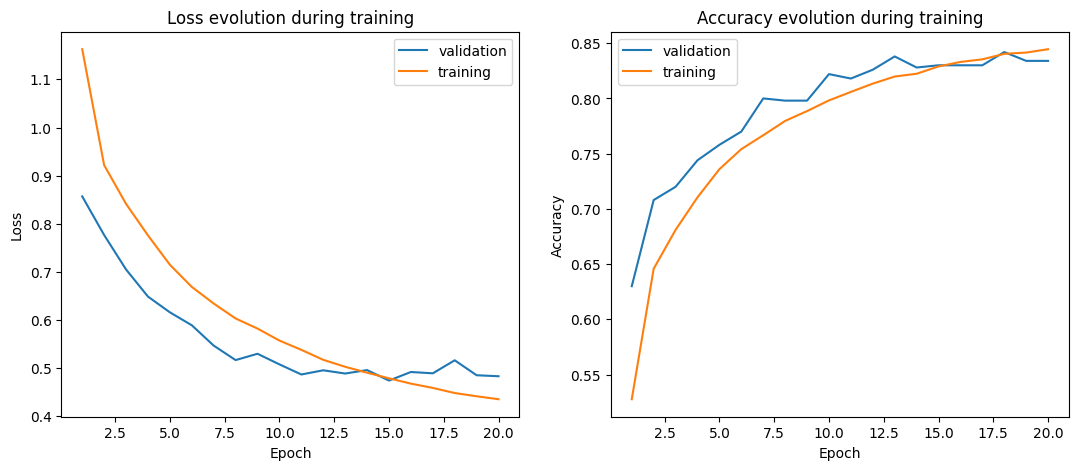

In [89]:
# Instanciación del modelo
lr = 5e-5
dropout_p = 0.6
batch_size = 16
criterion = nn.CrossEntropyLoss()
epochs = 50
model = CNNModel(dropout_p=dropout_p)

curves = train_model(
    model,
    Train_images,  
    Train_labels,
    Val_images,    
    Val_labels,
    epochs,
    criterion,
    batch_size,
    lr,
    use_gpu=True,
)

# Mostrar las curvas de entrenamiento
show_curves(curves)



              precision    recall  f1-score   support

         AGN       0.86      0.83      0.85       100
          SN       0.82      0.76      0.79       100
          VS       0.85      0.88      0.87       100
    asteroid       0.79      0.95      0.86       100
       bogus       0.94      0.83      0.88       100

    accuracy                           0.85       500
   macro avg       0.85      0.85      0.85       500
weighted avg       0.85      0.85      0.85       500



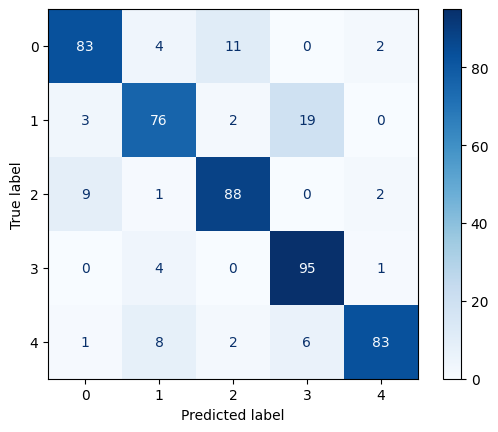

In [90]:
def predict(model, data_loader, use_gpu):
    all_preds = []
    all_true = []
    
    if use_gpu:
        model = model.cuda()  # Transfiere el modelo a la GPU
    
    model.eval()
    with torch.no_grad():
        for inputs, labels in data_loader:
            if use_gpu:
                inputs = inputs.cuda()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_true.extend(labels.numpy())

    return all_true, all_preds

Test_images = preparar_imagenes_para_modelo(data_procesada, key_principal='Test')
Test_labels = extraer_etiquetas(data_procesada, key_principal='Test')
# Definición de dataloader
test_dataset = torch.utils.data.TensorDataset(Test_images, Test_labels)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

true_labels, predicted_labels = predict(model, test_loader, use_gpu=True)
cm = confusion_matrix(true_labels, predicted_labels)

# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3, 4])
disp.plot(cmap=plt.cm.Blues)

report = classification_report(true_labels, predicted_labels, target_names=['AGN', 'SN', 'VS', 'asteroid', 'bogus'])

print(report)


### Segunda combinación de hiperparámetros

Epoch 1/50
Val loss: 0.8984180092811584, Val acc: 0.638
Epoch 2/50
Val loss: 0.8574293255805969, Val acc: 0.656
Epoch 3/50
Val loss: 0.8003561496734619, Val acc: 0.688
Epoch 4/50
Val loss: 0.7441869378089905, Val acc: 0.72
Epoch 5/50
Val loss: 0.6701233386993408, Val acc: 0.74
Epoch 6/50
Val loss: 0.625719428062439, Val acc: 0.754
Epoch 7/50
Val loss: 0.6353311538696289, Val acc: 0.748
Epoch 8/50
Val loss: 0.5896148085594177, Val acc: 0.774
Epoch 9/50
Val loss: 0.6102104783058167, Val acc: 0.77
Epoch 10/50
Val loss: 0.5972970128059387, Val acc: 0.788
Epoch 11/50
Val loss: 0.5671419501304626, Val acc: 0.79
Epoch 12/50
Val loss: 0.5636453628540039, Val acc: 0.8
Epoch 13/50
Val loss: 0.5653440952301025, Val acc: 0.8
Epoch 14/50
Val loss: 0.5513250827789307, Val acc: 0.796
Epoch 15/50
Val loss: 0.5548973679542542, Val acc: 0.802
Epoch 16/50
Val loss: 0.5344364643096924, Val acc: 0.808
Epoch 17/50
Val loss: 0.5076505541801453, Val acc: 0.808
Epoch 18/50
Val loss: 0.5229613780975342, Val acc

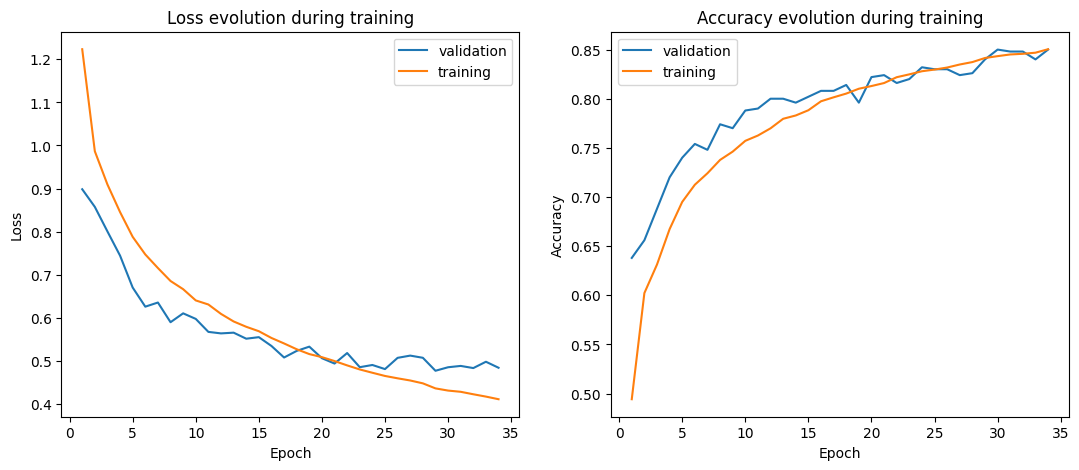

In [91]:
# Instanciación del modelo
lr = 5e-5
dropout_p = 0.6
batch_size = 32
criterion = nn.CrossEntropyLoss()
epochs = 50
model = CNNModel(dropout_p=dropout_p)

curves = train_model(
    model,
    Train_images,  
    Train_labels,
    Val_images,    
    Val_labels,
    epochs,
    criterion,
    batch_size,
    lr,
    use_gpu=True,
)

# Mostrar las curvas de entrenamiento
show_curves(curves)


              precision    recall  f1-score   support

         AGN       0.82      0.87      0.84       100
          SN       0.83      0.79      0.81       100
          VS       0.91      0.81      0.86       100
    asteroid       0.84      0.93      0.88       100
       bogus       0.91      0.90      0.90       100

    accuracy                           0.86       500
   macro avg       0.86      0.86      0.86       500
weighted avg       0.86      0.86      0.86       500



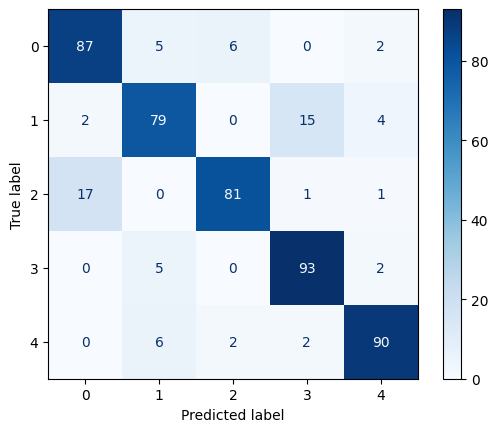

In [92]:
Test_images = preparar_imagenes_para_modelo(data_procesada, key_principal='Test')
Test_labels = extraer_etiquetas(data_procesada, key_principal='Test')
# Definición de dataloader
test_dataset = torch.utils.data.TensorDataset(Test_images, Test_labels)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

true_labels, predicted_labels = predict(model, test_loader, use_gpu=True)
cm = confusion_matrix(true_labels, predicted_labels)

# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3, 4])
disp.plot(cmap=plt.cm.Blues)

report = classification_report(true_labels, predicted_labels, target_names=['AGN', 'SN', 'VS', 'asteroid', 'bogus'])

print(report)


### Tercera combinación de hiperparámtros

Epoch 1/50
Val loss: 1.4373621940612793, Val acc: 0.416
Epoch 2/50
Val loss: 1.2747392654418945, Val acc: 0.498
Epoch 3/50
Val loss: 1.171807885169983, Val acc: 0.542
Epoch 4/50
Val loss: 1.1126517057418823, Val acc: 0.562
Epoch 5/50
Val loss: 1.0759730339050293, Val acc: 0.58
Epoch 6/50
Val loss: 1.0401020050048828, Val acc: 0.59
Epoch 7/50
Val loss: 1.0054726600646973, Val acc: 0.59
Epoch 8/50
Val loss: 0.9837875366210938, Val acc: 0.614
Epoch 9/50
Val loss: 0.9592428803443909, Val acc: 0.632
Epoch 10/50
Val loss: 0.9328038692474365, Val acc: 0.638
Epoch 11/50
Val loss: 0.9140123128890991, Val acc: 0.642
Epoch 12/50
Val loss: 0.8994582891464233, Val acc: 0.644
Epoch 13/50
Val loss: 0.8855694532394409, Val acc: 0.646
Epoch 14/50
Val loss: 0.8800592422485352, Val acc: 0.644
Epoch 15/50
Val loss: 0.8688142895698547, Val acc: 0.656
Epoch 16/50
Val loss: 0.8653697967529297, Val acc: 0.654
Epoch 17/50
Val loss: 0.8547067642211914, Val acc: 0.664
Epoch 18/50
Val loss: 0.8477159738540649, Va

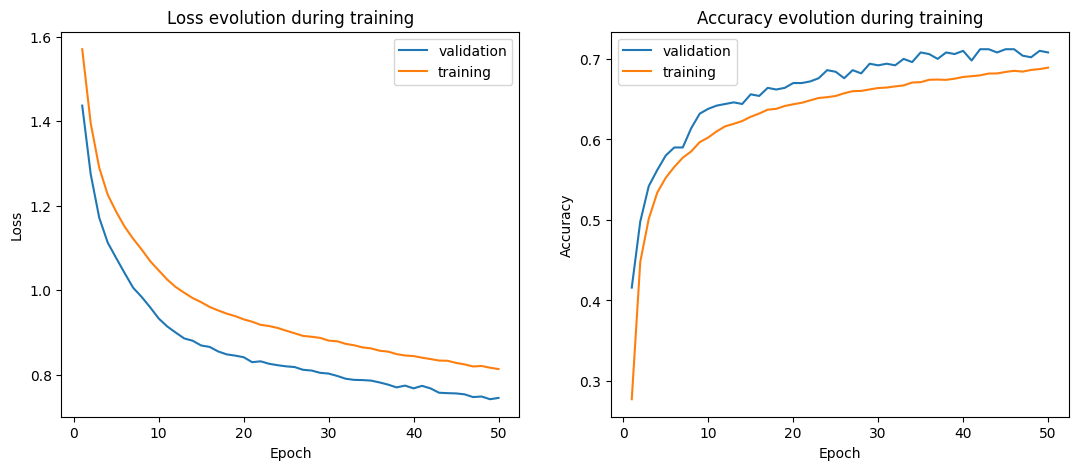

In [93]:
# Instanciación del modelo
lr = 5e-6
dropout_p = 0.6
batch_size = 32
criterion = nn.CrossEntropyLoss()
epochs = 50
model = CNNModel(dropout_p=dropout_p)

curves = train_model(
    model,
    Train_images,  
    Train_labels,
    Val_images,    
    Val_labels,
    epochs,
    criterion,
    batch_size,
    lr,
    use_gpu=True,
)

# Mostrar las curvas de entrenamiento
show_curves(curves)


              precision    recall  f1-score   support

         AGN       0.81      0.73      0.77       100
          SN       0.69      0.54      0.61       100
          VS       0.76      0.82      0.79       100
    asteroid       0.78      0.89      0.83       100
       bogus       0.73      0.80      0.76       100

    accuracy                           0.76       500
   macro avg       0.75      0.76      0.75       500
weighted avg       0.75      0.76      0.75       500



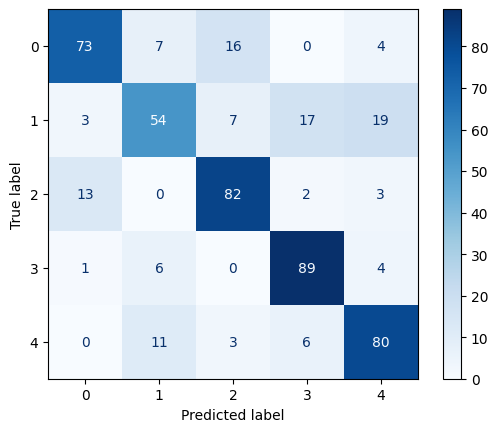

In [94]:
Test_images = preparar_imagenes_para_modelo(data_procesada, key_principal='Test')
Test_labels = extraer_etiquetas(data_procesada, key_principal='Test')
# Definición de dataloader
test_dataset = torch.utils.data.TensorDataset(Test_images, Test_labels)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

true_labels, predicted_labels = predict(model, test_loader, use_gpu=True)
cm = confusion_matrix(true_labels, predicted_labels)

# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3, 4])
disp.plot(cmap=plt.cm.Blues)

report = classification_report(true_labels, predicted_labels, target_names=['AGN', 'SN', 'VS', 'asteroid', 'bogus'])

print(report)
